<a href="https://colab.research.google.com/github/AriyanaC/Internship-project--IDEAS-Institute-of-Data-Engineering-Analytics-and-Science-Foundation-ISI-Kolkata/blob/main/Copy_of_04_fake_news_detection_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Name: Fake News Detection and Evaluation with Confusion Matrix**
####**created by: Suprava Das**

# **Problem Statement:**


This project addresses the challenge of distinguishing fake news from true news using machine learning techniques. A classification model is trained on textual data, and its effectiveness is evaluated through a confusion matrix to assess accuracy and misclassification patterns.

# **Data Introduction:**

This dataset was compiled from real-world sources; the genuine articles were scraped from Reuters.com (a reputable news website). In contrast, the fake news articles were gathered from various unreliable platforms identified by Politifact (a U.S.-based fact-checking organization) and Wikipedia. The collection covers articles on diverse subjects, though most of them center around politics and world news.

The dataset cab also be downloaded from kaggle using the link: www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets

# **Import Packages**

Imported all required libraries and installed any missing packages in Google Colab.

In [1]:
pip install gensim

In [3]:
# import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# mounted the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Data Preprocessing**

In [ ]:
# read the csv file using pandas dataframe
fake_news_data = pd.read_csv('/content/fake.csv')
true_news_data = pd.read_csv('/content/true.csv')

**Q1.** View the imported csv file data using Pandas Dataframe.

In [ ]:
display(fake_news_data.head())
display(true_news_data.head())

In [ ]:
fake_news_data["class"] = 1  # Fake News data → 1
true_news_data["class"] = 0  # True News data → 0

In [ ]:
# merged true and fake news datasets
merged_data = [fake_news_data,true_news_data]
df = pd.concat(merged_data,axis=0)

**Q2.** drop rows from the dataset consisting null values.

In [ ]:
df = df.dropna()

**Q3.** shuffle the data.

In [ ]:
df = df.sample(frac=1)

In [ ]:
#reset index of the merged dataframe
df = df.reset_index(drop=True)

In [ ]:
# view top 10 rows of processed dataset
df.head(10)

,title,text,subject,date
0,Trump Administration IRATE After Judge Halts ...,Following a Boston judge s refusal to renew th...,News,"February 4, 2017"
1,#Berkeley IRONY ALERT! ANARCHISTS LOOT STARBUC...,Smashing windows How progressive!Protests aga...,politics,"Feb 2, 2017"
2,"Stirred by same-sex marriage vote, Australia's...",SYDNEY (Reuters) - It was supposed to relieve ...,worldnews,"October 6, 2017"
3,CONDOLEEZZA RICE BRILLIANTLY Shuts Down “The V...,"On more than one occasion, Condoleezza Rice wa...",politics,"May 10, 2017"
4,DEPARTMENT OF JUSTICE Fines Sheriff For Exclud...,From Wikipedia:The Immigration and Nationality...,Government News,"Nov 21, 2016"
5,LOL! SOCIAL MEDIA Users Respond To Hillary’s B...,Exactly one year ago today on arrogant Hillary...,politics,"Oct 26, 2017"
6,French minister says U.S. energy secretary has...,ROME (Reuters) - U.S. energy secretary Rick Pe...,politicsNews,"April 10, 2017"
7,Abbas: Palestinians will go to Security Counci...,CAIRO (Reuters) - Palestinian President Mahmou...,worldnews,"December 13, 2017"
8,Four Serbs get suspended sentences for 2008 at...,BELGRADE (Reuters) - Four Serbian men got susp...,worldnews,"November 14, 2017"
9,Republican Sandoval withdraws as possible Supr...,WASHINGTON (Reuters) - Nevada Governor Brian S...,politicsNews,"February 25, 2016"


**Q4.** view the text content of a random data point.

In [ ]:
random_row = df.sample(n=1)
random_text_content = random_row.iloc[0]["text"]
print(random_text_content)

(Reuters) - A sales consultant told Brazilian prosecutors he believes planemaker Embraer SA’s top officials, including Chief Executive Frederico Curado, knew of illicit payments related to the sale of military aircraft to the Dominican Republic, the Wall Street Journal reported. Embraer is under investigation by the U.S. and Brazilian authorities for allegedly bribing officials in the Dominican Republic to secure deals for commercial and defense aircraft. According to official summaries of sales consultant Elio Moti Sonnenfeld’s statements, he received a payment of $3.4 million from Embraer for work he did not perform, and which he passed along as a bribe to a public official in the Dominican Republic, the newspaper reported on Wednesday.  The Journal, citing a person close to the case, reported on Thursday that a Brazilian judge had dismissed criminal charges against Sonnenfeld in February.  The alleged bribery helped Embraer secure a $92 million contract in 2008 to sell eight turbopr

**Data Visualization**

Text(0, 0.5, 'Number of News')

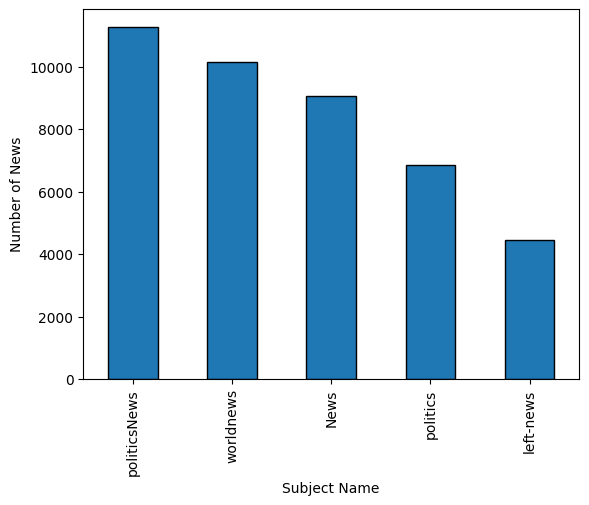

In [ ]:
#create a data visualzation of bar/column/line chart of top 5 subjects ->
top_5_subjects = (df['subject'].value_counts()).nlargest(5)
top_5_subjects.plot(kind='bar', edgecolor='black', stacked=True)
plt.xlabel('Subject Name')
plt.ylabel('Number of News')

**Q5.** Create a pie chart to find the percentage of news on different subject.

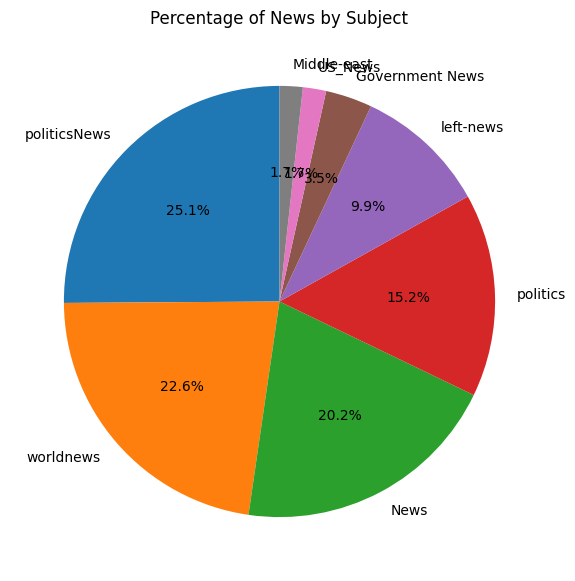

In [ ]:
plt.figure(figsize=(10,7))
df['subject'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Percentage of News by Subject')
plt.ylabel('')
plt.show()

**Text Processing**

In [ ]:
# function to remove space,special charecter and convert all text into lower case
def wordopt(text):
  text = text.lower()
  text= re.sub(r'https://\S+|www\.\S+','',text) # remove https:// or www.com
  text = re.sub(r'[^\w]',' ', text) #remove special charecter
  text= re.sub(r'\s+',' ',text) #remove multiple space

  return text

In [ ]:
# drop unnecessary columns for classification purpose
df1= df.drop(['title','subject','date'],axis=1)

In [ ]:
# apply wordopt method to the whole dataset and view the text content of a random data point
df1['text']=df1['text'].apply(wordopt)
df1['text'][100]

' reuters a colorado judge rejected a request to extend voting time in the state past 7 p m despite an earlier computer glitch according to a tweet from the mayor of denver s office of emergency management '

# **Building Model**

In [ ]:
# Separate independent and target columns from the dataset and stored them in x & y variables
x= df1['text']
y= df1['text']

**Q6.** Split the dataset into training and testing sets with 25% test size and store them in x_train, x_test, y_train, and y_test.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

## **Word Embedding ( Word2Vec )**

In [ ]:
# import bbc_news data using url link in json format for training Word2Vec word embedding model
news = pd.read_json('https://query.data.world/s/7c6p2lxb3wjibfsfbp4mwy7p7y4y2d?dws=00000')
news_seg = news['content']
print("Size of Word Dictonary for training Word2Vec: ",news_seg.shape[0])
news_seg.head(2)

Size of Word Dictonary for training Word2Vec:  15825


,content
0,The heroin substitute methadone can be used as...
1,The eldest son of North Korean leader Kim Jong...


In [ ]:
# apply wordopt function for text processing
news_seg=news_seg.apply(wordopt)
sentences = [sentence.split() for sentence in news_seg ]
w2v_model = Word2Vec(sentences,  window=5, min_count=5, workers=4)

In [ ]:
# function to convert a sentence into vector form
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
# convert train and test dataset into vector form
xv_train = np.array([vectorize(sentence) for sentence in x_train])
xv_test = np.array([vectorize(sentence) for sentence in x_test])

##**Logistic Regression**

In [ ]:
# Trains a Logistic Regression model using vector formed trained data ->
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(xv_train,y_train)

In [ ]:
# detect the class(fake or true) on test data and evaluates its accuracy on test set
y_pred = logistic_model.predict(xv_test)
print("Prediction on test data: ",y_pred)
print("Accuracy Score on Test Data: ",logistic_model.score(xv_test,y_test))

####**Accuracy Checking**

In [ ]:
# Check Precision, Recall, F1 Score of the logistic model ->
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

In [ ]:
# Check overall accuracy using confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm= confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

##**Random Forest Classifier**

####**Model Building and Prediction**

**Q7.** Use Random Forest Classifer for this classfication purpose and predict the outcomes for test data.

In [2]:
from sklearn.ensemble import RandomForestClassifier
#Initialise and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(xv_train,y_train)

#Predict on the test data
y_pred = rf_model.predict(xv_test)
print("Prediction on test data using Random Forest:", y_pred_rf)

ModuleNotFoundError: No module named 'numpy.rec'

####**Accuracy Checking**

**Q8.** Find the accuracy, precison, recall, F1 Score of the model while using Random Forest Classsifier and visualize overall accuracy using confusion matrix.

In [ ]:
#Check Precision, Recall, F1 score of the Random Forest model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

#check overall accuracy using confusion matrix
cm= confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

#**Save the Model using pickle**

In [ ]:
# save the logistic regression model as pickle file
import pickle
filename1 = '/content/drive/My Drive/IDEAS-TIH/Internship_2025/word2vec_logistic_model.pickle'
pickle.dump(logistic_model, open(filename1, 'wb')) #word2vec model

In [ ]:
# Load the pickle file and checkout model score
loaded_model = pickle.load(open(filename1, 'rb'))
result = loaded_model.score(xv_test, y_test)
print(result)

**Q9.** Save the trained Random Forest Model as pickle/svg file in your desired repository for further use.

In [ ]:
#Save the Random Forest model as a pickle file
filename2 = '/content/drive/my Drive/IDEAS-TIH/Internship_2025/word2vec_random_forest_model.pickle'
pickle.dump(rf_model, open(filename2, "wb"))

**Q10.** Load that saved model in another Notebook. Use it on other dataset for fake news detection.

In [ ]:
# To mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Defines the wordopt function again for text processing on the new data
def wordopt(text):
  text = text.lower()
  text= re.sub(r'https://\S+|www\.\S+','',text) # removes https:// or www.com
  text = re.sub(r'[^\w]',' ', text) #removes special characters
  text= re.sub(r'\s+',' ',text) #removes multiple spaces
  return text

# import bbc_news data using url link in json format for training Word2Vec word embedding model
news = pd.read_json('https://query.data.world/s/7c6p2lxb3wjibfsfbp4mwy7p7y4y2d?dws=00000')
news_seg = news['content']
print("Size of Word Dictonary for training Word2Vec: ",news_seg.shape[0])
news_seg.head(2)

# Define the vectorize function again to convert sentences to vectors
def vectorize(sentence):
    words = sentence.split()
    if 'w2v_model' not in globals():
        print("Word2Vec model not found. Please load or train the model.")
        return np.zeros(100) # Return a zero vector if model is not available

    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

filename2 = '/content/drive/My Drive/IDEAS-TIH/Internship_2025/word2vec_random_forest_model.pickle'
loaded_rf_model = pickle.load(open(filename2, "rb"))

new_fake_news_data = pd.read_csv('/content/drive/My Drive/IDEAS-TIH/Internship_2025/Fake.csv')

# Apply the wordopt function to the new dataset
new_fake_news_data['text'] = new_fake_news_data['text'].apply(wordopt)

# Convert the text data in the new dataset to vector form using the same vectorize function
xv_new_data = np.array([vectorize(sentence) for sentence in new_fake_news_data['text']])

# Predict the class (fake or true) on the new data
predictions = loaded_rf_model.predict(xv_new_data)

# Add the predictions as a new column to your new dataset
new_fake_news_data['predicted_class'] = predictions

# Display the new dataset with predictions
display(new_fake_news_data.head())

print("Predicted class distribution on new data:")
print(new_fake_news_data['predicted_class'].value_counts())


**Q11(Optional).**


1.  Try to enhance the model's accuracy by using adaboost or any other boosting methods.
2.  Use TF-IDF or any other vectorizer instead of Word2Vec and study how much it affects on model's accuracy.




